In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from diffusers import StableUnCLIPImg2ImgPipeline, DDIMScheduler
from diffusers.utils import load_image
from tqdm import tqdm
import numpy as np
from openai import OpenAI
import torch

from PIL import Image
import os

from dataset import PetsDataset

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

4


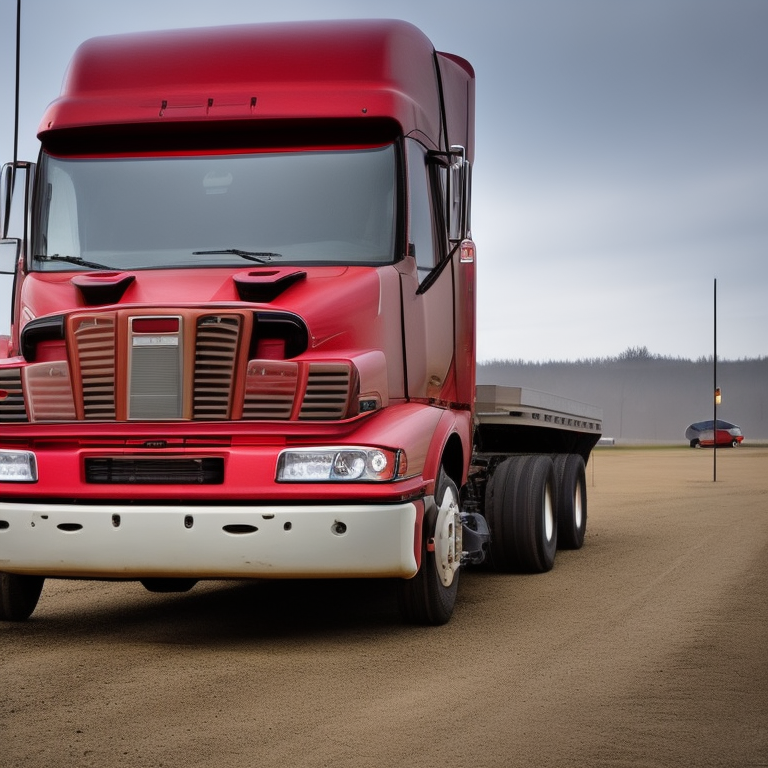

In [45]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

model_id = "stabilityai/stable-diffusion-2-1"

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DDIMScheduler.from_config(
    pipe.scheduler.config, rescale_betas_zero_snr=True, timestep_spacing="trailing"
)
pipe = pipe.to("cuda")

prompt = ["truck", "cat"]
images = pipe(prompt, num_inference_steps=20, guidance_scale=9, num_images_per_prompt=2).images
image = images[0]
print(len(images))
image


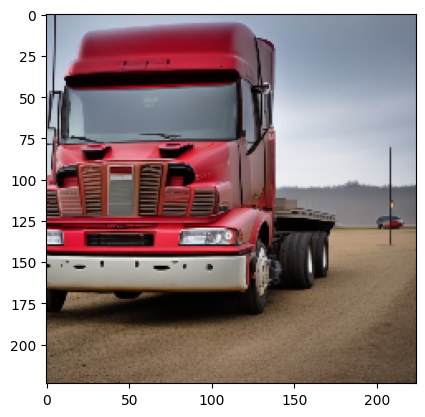

In [46]:
# reshape each PIL image to 224x224
image_size = 224
import cv2
# convert PIL images to numpy arrays
images = [np.array(img) for img in images]
# images = [img.resize((224, 224)) for img in images]
# images = [(img * 255.0).astype(np.uint8) for img in images]
images = [cv2.resize(img, (image_size, image_size)) for img in images]
images[0]
import matplotlib.pyplot as plt
plt.imshow(images[0])

In [5]:
model_name = "stabilityai/stable-diffusion-2-1-unclip"
pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    model_name, torch_dtype=torch.float16
)
pipe.scheduler = DDIMScheduler.from_config(
    pipe.scheduler.config, rescale_betas_zero_snr=True, timestep_spacing="trailing"
)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

In [6]:
def calculate_image_embeds(pipe: StableUnCLIPImg2ImgPipeline, input_image: Image.Image) -> torch.Tensor:
    """Calculate image embeddings using the image encoder of the pipeline.
    Args:
        pipe: The pipeline object.
        input_image: The input image.
    Returns:
        torch.Tensor: The image embeddings. shape of (1, 1024).
    """
    # Preprocess image
    image = pipe.feature_extractor(images=input_image, return_tensors="pt").pixel_values
    image = image.to(device)

    image_embeds = pipe.image_encoder(image).image_embeds
    return image_embeds

In [7]:
dataset = PetsDataset(
    "../data",
    transform=pipe.feature_extractor,
)

from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

pets_cls_dict = {}

prev_key = None
for i, item in tqdm(enumerate(dataset), total=len(dataset)):
    key = item["path"].split("/")[-1].split("_")[0]
    if prev_key is None:
        prev_key = key
        pets_cls_dict[key] = []
    
    if prev_key != key:
        prev_key = key
        pets_cls_dict[key] = []
        
    pets_cls_dict[prev_key].append(i)

100%|██████████| 3680/3680 [00:18<00:00, 197.80it/s]


In [8]:
pets_cls_dict.keys()

dict_keys(['Abyssinian', 'american', 'basset', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British', 'chihuahua', 'Egyptian', 'english', 'german', 'great', 'havanese', 'japanese', 'keeshond', 'leonberger', 'Maine', 'miniature', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian', 'saint', 'samoyed', 'scottish', 'shiba', 'Siamese', 'Sphynx', 'staffordshire', 'wheaten', 'yorkshire'])

In [9]:
# generate text embeddings
def calculate_text_embeds(pipe: StableUnCLIPImg2ImgPipeline, text: str) -> torch.Tensor:
    """Calculate text embeddings using the text encoder of the pipeline.
    Args:
        pipe: The pipeline object.
        text: The input text.
    Returns:
        torch.Tensor: The text embeddings. shape of (1, 1024).
    """
    text_inputs = pipe.tokenizer(
        text,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids.to(device)
    text_embeds = pipe.text_encoder(text_input_ids).pooler_output
    text_embeds = pipe.text_encoder.text_model.final_layer_norm(text_embeds)
    
    return text_embeds

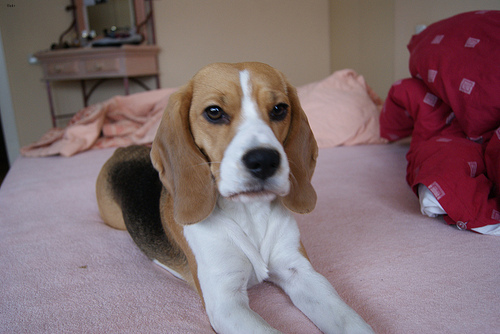

In [10]:
sample = dataset[203]
sample_img = load_image(sample["path"])
sample_img

In [25]:
# set random seed
output = pipe(image=sample_img, num_inference_steps=20, eta=0.0, noise_level=10, prompt="truck")

  0%|          | 0/20 [00:00<?, ?it/s]

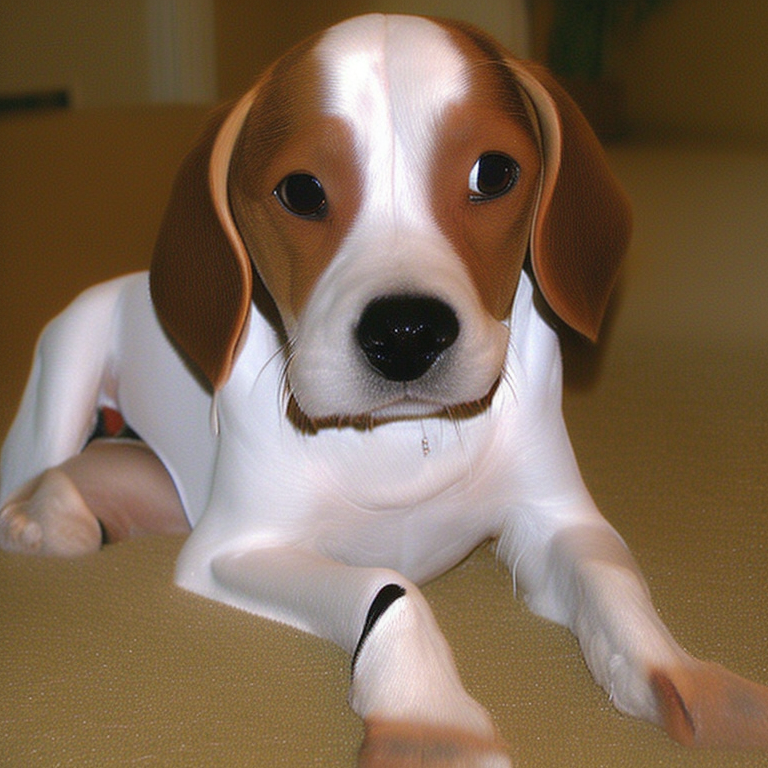

In [26]:
output.images[0]

In [27]:
height, width = None, None
height = height or pipe.unet.config.sample_size * pipe.vae_scale_factor
width = width or pipe.unet.config.sample_size * pipe.vae_scale_factor
print(height, width)
print(pipe.unet.config.sample_size, pipe.vae_scale_factor)

768 768
96 8


In [46]:
num_images_per_prompt = 1
batch_size = 1
batch_size = batch_size * num_images_per_prompt

steps = 20
guidance_scale = 0
do_classifier_guidance = guidance_scale > 0.0

In [47]:
from typing import List, Optional
def encode_prompt(
    pipe,
    prompt,
    device,
    num_images_per_prompt,
    do_classifier_free_guidance,
    prompt_embeds: Optional[torch.Tensor] = None,
):
    r"""
    Encodes the prompt into text encoder hidden states.

    Args:
        prompt (`str` or `List[str]`, *optional*):
            prompt to be encoded
        device: (`torch.device`):
            torch device
        num_images_per_prompt (`int`):
            number of images that should be generated per prompt
        do_classifier_free_guidance (`bool`):
            whether to use classifier free guidance or not
        prompt_embeds (`torch.Tensor`, *optional*):
            Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
            provided, text embeddings will be generated from `prompt` input argument.
    """
    if prompt is not None and isinstance(prompt, str):
        batch_size = 1
    elif prompt is not None and isinstance(prompt, list):
        batch_size = len(prompt)
    else:
        batch_size = prompt_embeds.shape[0]

    if prompt_embeds is None:
        text_inputs = pipe.tokenizer(
            prompt,
            padding="max_length",
            max_length=pipe.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        untruncated_ids = pipe.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

        if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
            text_input_ids, untruncated_ids
        ):
            removed_text = pipe.tokenizer.batch_decode(
                untruncated_ids[:, pipe.tokenizer.model_max_length - 1 : -1]
            )

        if hasattr(pipe.text_encoder.config, "use_attention_mask") and pipe.text_encoder.config.use_attention_mask:
            attention_mask = text_inputs.attention_mask.to(device)
        else:
            attention_mask = None

        prompt_embeds = pipe.text_encoder(text_input_ids.to(device), attention_mask=attention_mask)
        prompt_embeds = prompt_embeds[0]

    if pipe.text_encoder is not None:
        prompt_embeds_dtype = pipe.text_encoder.dtype
    elif pipe.unet is not None:
        prompt_embeds_dtype = pipe.unet.dtype
    else:
        prompt_embeds_dtype = prompt_embeds.dtype

    prompt_embeds = prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

    bs_embed, seq_len, _ = prompt_embeds.shape
    # duplicate text embeddings for each generation per prompt, using mps friendly method
    prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
    prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

    # get unconditional embeddings for classifier free guidance
    uncond_tokens = [""] * batch_size

    max_length = prompt_embeds.shape[1]
    uncond_input = pipe.tokenizer(
        uncond_tokens,
        padding="max_length",
        max_length=max_length,
        truncation=True,
        return_tensors="pt",
    )

    if hasattr(pipe.text_encoder.config, "use_attention_mask") and pipe.text_encoder.config.use_attention_mask:
        attention_mask = uncond_input.attention_mask.to(device)
    else:
        attention_mask = None

    uncond_prompt_embeds = pipe.text_encoder(
        uncond_input.input_ids.to(device),
        attention_mask=attention_mask,
    )
    uncond_prompt_embeds = uncond_prompt_embeds[0]
    
    # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
    seq_len = uncond_prompt_embeds.shape[1]

    uncond_prompt_embeds = uncond_prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

    uncond_prompt_embeds = uncond_prompt_embeds.repeat(1, num_images_per_prompt, 1)
    uncond_prompt_embeds = uncond_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

    return prompt_embeds, uncond_prompt_embeds

In [60]:
prompt = "truck"
prompt_embeds, uncond_prompt_embeds = encode_prompt(pipe, prompt, device, num_images_per_prompt, do_classifier_guidance)
if do_classifier_guidance:
    prompt_embeds = torch.cat([prompt_embeds, uncond_prompt_embeds])
else:
    # prompt_embeds = uncond_prompt_embeds   
    prompt_embeds = prompt_embeds
prompt_embeds.shape

torch.Size([1, 77, 1024])

In [61]:
from diffusers.models.embeddings import get_timestep_embedding

def noise_image_embeddings(image_embeds, noise_level, noise=None):
    if noise is None:
        noise = torch.randn_like(image_embeds, device=image_embeds.device, dtype=image_embeds.dtype)
    
    noise_level = torch.tensor([noise_level] * image_embeds.shape[0], device=image_embeds.device)
    pipe.image_normalizer.to(image_embeds.device)
    
    image_embeds = pipe.image_normalizer.scale(image_embeds)
    image_embeds = pipe.image_noising_scheduler.add_noise(image_embeds, timesteps=noise_level, noise=noise)
    image_embeds = pipe.image_normalizer.unscale(image_embeds)
    
    noise_level = get_timestep_embedding(
        timesteps=noise_level, embedding_dim=image_embeds.shape[-1], flip_sin_to_cos=True, downscale_freq_shift=0
    ).to(image_embeds.device)
    
    image_embeds = torch.cat([image_embeds, noise_level], dim=1)  
    return image_embeds
    

def encode_image(pipe, image, device, batch_size, num_images_per_prompt, do_classifier_guidance, noise_level, image_embeds):
    dtype = next(pipe.image_encoder.parameters()).dtype 
    if isinstance(image, Image.Image):
        repeat_by = batch_size
    else:
        repeat_by = num_images_per_prompt
    
    if image_embeds is None:
        if not isinstance(image, torch.Tensor):
            image = pipe.feature_extractor(images=image, return_tensors="pt").pixel_values
        image = image.to(device, dtype=dtype) 
        image_embeds = pipe.image_encoder(image).image_embeds
    
    # add noise to image embeddings
    image_embeds = noise_image_embeddings(
        image_embeds, noise_level
    )  # (batch_size, image_embeds_dim)
    
    image_embeds = image_embeds.unsqueeze(1)
    bs_embed, seq_len, _ = image_embeds.shape
    image_embeds = image_embeds.repeat(1, repeat_by, 1)
    image_embeds = image_embeds.view(bs_embed * repeat_by, seq_len, -1)
    image_embeds = image_embeds.squeeze(1)
    
    if do_classifier_guidance:
        # for unconditional guidance, we use zeroed out embeddings
        uncond_image_embeds = torch.zeros_like(image_embeds)
        image_embeds = torch.cat([uncond_image_embeds, image_embeds])
    else:
        image_embeds = torch.zeros_like(image_embeds)
    return image_embeds

image_embeds = encode_image(pipe, sample_img, device, batch_size, num_images_per_prompt, do_classifier_guidance, 0, None)
image_embeds = torch.zeros_like(image_embeds, device=device, dtype=prompt_embeds.dtype)
image_embeds = image_embeds.to(device, dtype=prompt_embeds.dtype)
# image_embeds = torch.zeros_like(image_embeds, device=device, dtype=prompt_embeds.dtype)
image_embeds.shape  # (batch_size, image_embeds_dim * 2)

torch.Size([1, 2048])

In [62]:
pipe.scheduler.set_timesteps(num_inference_steps=steps, device=device)
timesteps = pipe.scheduler.timesteps
timesteps

tensor([999, 949, 899, 849, 799, 749, 699, 649, 599, 549, 499, 449, 399, 349,
        299, 249, 199, 149,  99,  49], device='cuda:0')

In [63]:
num_channels_latents = pipe.unet.config.in_channels
latents = None

def prepare_latents(batch_size, num_channels_latents, height, width, dtype, device, latents=None):
    shape = (
        batch_size,
        num_channels_latents,
        int(height) // pipe.vae_scale_factor,
        int(width) // pipe.vae_scale_factor,
    )
    if latents is None:
        latents = torch.randn(shape, dtype=dtype, device=device)
    else:
        latents = latents.to(dtype=dtype, device=device)

    # scale the initial noise by the standard deviation of the unet
    latents = latents * pipe.scheduler.init_noise_sigma
    return latents

latent_shape = (batch_size, num_channels_latents, height // pipe.vae_scale_factor, width // pipe.vae_scale_factor)
latents_source = None # torch.randn(latent_shape, dtype=prompt_embeds.dtype, device=device)
if latents_source is None:
    print(f"Initialize Latents")
    latents_source = prepare_latents(batch_size, num_channels_latents, height, width, prompt_embeds.dtype, device, latents)
latents_source.shape

Initialize Latents


torch.Size([1, 4, 96, 96])

In [64]:
# Denoising Loop
# pipe.scheduler.set_timesteps(num_inference_steps=steps, device=device)
pipe.scheduler.set_timesteps(num_inference_steps=15, device=device)
timesteps = pipe.scheduler.timesteps

latents = latents_source.clone()
for i, t in enumerate(pipe.progress_bar(timesteps)):
    latent_model_input = torch.cat([latents] * 2) if do_classifier_guidance else latents
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    
    with torch.no_grad():
        noise_pred = pipe.unet(
            latent_model_input,
            t,
            encoder_hidden_states=prompt_embeds,
            class_labels=image_embeds,
            # class_labels=torch.zeros_like(image_embeds),
            return_dict=False
        )[0]
    
    if do_classifier_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

output_type = "image"
pipe.vae.to(pipe.dtype)
if not output_type == "latent":
    image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]
else:
    image = latents

image = image.cpu().detach()
image = pipe.image_processor.postprocess(image, output_type=output_type)

  0%|          | 0/15 [00:00<?, ?it/s]

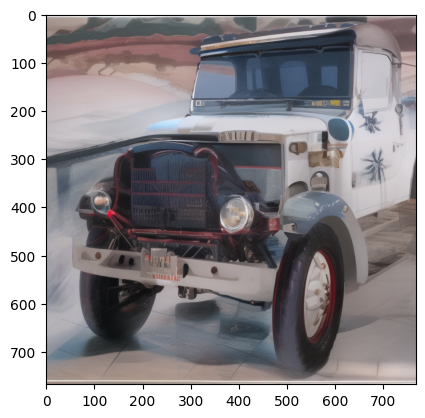

In [65]:
import matplotlib.pyplot as plt
plt.imshow(image[0])

In [21]:
# DDIM Inversion
from torch import Tensor
@torch.no_grad()
def encode(pipe, images: Tensor, device):
    # Zimages_scaled = images.to(device) 
    images_scaled = images.to(device) * 2 - 1  # scale to [-1, 1]
    pipe.vae.to(device, dtype=images_scaled.dtype)
    latents = pipe.vae.encode(images_scaled)
    l = pipe.vae.scaling_factor * latents.latent_dist.sample()  # empriical value for ensure the latent has unit variance.
    return l

@torch.no_grad()
def invert(
    pipe,
    start_latents, 
    prompt,
    image_embeds,
    guidance_scale=3.5,
    num_inference_steps=80,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt="",
    device="cuda",
    prefix="",
):
    # import pdb; pdb.set_trace()
    batch_size = start_latents.shape[0]
    
    # encode prompt, #TODO: implement per image prompt encoding, currently it is same for all images.
    text_emb = pipe._encode_prompt(
        prompt, device, batch_size, do_classifier_free_guidance, negative_prompt
    )
    
    latents = start_latents.clone()
    
    # TODO: why keep intermediate latents
    intermediate_latents = []
    
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    
    timesteps = reversed(pipe.scheduler.timesteps)
    
    if prefix is not None:
        print(f"{prefix}: Encoding Images for {num_inference_steps} steps...")
        
    for i in tqdm(range(1, num_inference_steps), total=num_inference_steps-1):
        #TODO: why skip final iteration, why start from 1.
        if i >= num_inference_steps - 1: continue
        
        t = timesteps[i]
        
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t).to(pipe.unet.dtype)
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_emb, class_labels=image_embeds).sample  # (2*B, C, H, W)
        
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2, dim=0)  # (B, C, H, W), (B, C, H, W)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
            
        current_t = max(0, t.item() - (1000//num_inference_steps))  # TODO: why?
        next_t = t
        alpha_t = pipe.scheduler.alphas_cumprod[current_t]
        alpha_t_next = pipe.scheduler.alphas_cumprod[next_t]
        
        latents = (latents - (1-alpha_t).sqrt() * noise_pred) * (alpha_t_next.sqrt()/alpha_t.sqrt()) + (1-alpha_t_next).sqrt() * noise_pred
        
        intermediate_latents.append(latents)
        
    return  intermediate_latents


In [22]:
# Encode
from torchvision import transforms as tfms
img_transform = tfms.Compose([
    tfms.Resize((height, width)),
    tfms.ToTensor(),
])

sample_img_t = img_transform(sample_img).unsqueeze(0)  # (1, 3, h, w)
sample_img_t.to(device=device, dtype=torch.float16)
encoded_img = encode(pipe, sample_img_t, device)  # (1, d, h, w)
print(encoded_img.shape)

# Image Embedding
image_embeds = encode_image(pipe, sample_img, device, batch_size, num_images_per_prompt, do_classifier_guidance, 0, None).to(pipe.dtype)
print(image_embeds.shape)
print(image_embeds.dtype)

# Invert
inverted_latents = invert(pipe, encoded_img, prompt, image_embeds, num_inference_steps=steps, num_images_per_prompt=1, do_classifier_free_guidance=True, device=device, guidance_scale=guidance_scale)

/tmp/ipykernel_389540/2711517433.py:9: FutureWarning: Accessing config attribute `scaling_factor` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'scaling_factor' over 'AutoencoderKL's config object instead, e.g. 'unet.config.scaling_factor'.
  l = pipe.vae.scaling_factor * latents.latent_dist.sample()  # empriical value for ensure the latent has unit variance.
/home/haselab/anaconda3/envs/diffae/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_unclip_img2img.py:175: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


torch.Size([1, 4, 96, 96])
torch.Size([2, 2048])
torch.float16
: Encoding Images for 50 steps...


100%|██████████| 49/49 [00:06<00:00,  8.16it/s]


In [324]:
timesteps

tensor([999, 966, 932, 899, 866, 832, 799, 766, 732, 699, 666, 632, 599, 566,
        532, 499, 466, 432, 399, 366, 332, 299, 266, 232, 199, 166, 132,  99,
         66,  32], device='cuda:1')

In [354]:
# Denoising Loop
start_step = 20
latents = inverted_latents[-(start_step+1)].clone()
noise = torch.randn_like(latents, device=latents.device, dtype=latents.dtype)
latents += 0.3 * noise

image_embeds = encode_image(pipe, sample_img, device, batch_size, num_images_per_prompt, do_classifier_guidance, 100, None).to(pipe.dtype)
# image_embeds = torch.zeros_like(image_embeds, device=device, dtype=pipe.dtype)

sub_timesteps = timesteps[start_step:steps]
for i, t in enumerate(pipe.progress_bar(sub_timesteps)):
    latent_model_input = torch.cat([latents] * 2) if do_classifier_guidance else latents
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t).to(pipe.unet.dtype)
    
    with torch.no_grad():
        noise_pred = pipe.unet(
            latent_model_input,
            t,
            encoder_hidden_states=prompt_embeds,
            class_labels=image_embeds,
            return_dict=False
        )[0]
    
    if do_classifier_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

output_type = "image"
if not output_type == "latent":
    image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]
else:
    image = latents

image = image.cpu().detach()
image = pipe.image_processor.postprocess(image, output_type=output_type)

100%|██████████| 10/10 [00:00<00:00, 13.53it/s]


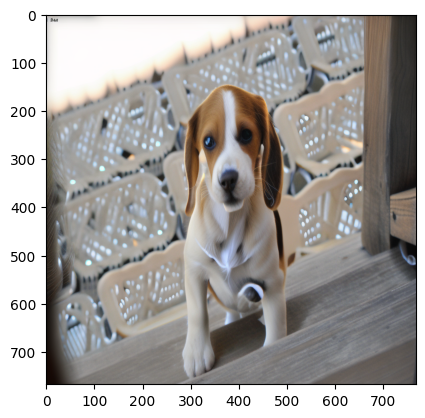

In [355]:
plt.imshow(image[0])